# Book Recommender

Goal of this project is to try out several different approaches to a book recommender system.

Data used here come from freely available dataset: http://www2.informatik.uni-freiburg.de/~cziegler/BX/

## Data

The data set contains three tables:
 - books: 250k+ books with ISBN, title, author, year of publication, publisher, and URLs containing book covers
 - ratings: 1.1M+ ratings of the books from 100k users, split into implicit (given by 0) and explicit (given by ints 1 to 10) ratings
 - users: information on user age and location (approx. half of the users have age missing)

## Approaches

I took three approaches to making recommendations. In all of them, the **input** is a string containing a (part) of title of a book of out liking, for which we are looking for similar books. If there are more books with the input title, the recommender continues with the one with highest number of reviews.

Each method recommends **n** books which user might like (I set n = 5).

1. **Recommendation based on bibliographic similarity**: The idea is to recommend books from the same author, publisher, and time period, or with similar titles (i.e. continuation of a series).
    - I added two features representing time period (tens) when the book was published, and second most adjecent period, to increase similarity between books from similar time, but not the same year
    - Then I created string feature 'info' by concatanating book title, author, year, publisher, period1, period2
    - Based on 'info' I created binary term frequency matrix with shape (*n. of unique ISBNs*, *n. of unique terms in 'info'*)
    - I computed cosine similarity between input_book and all other books in the term matrix, and selected n+1 most similar books (then excluded the input book).


2. **Recommendation based on explicit ratings**: Users that liked the input book are likely to have the same taste as us. Hence the goal here is to recommend books that are similar as the input book in terms of users that rated the books and also in terms of the ratings themselves.
    - I created sparse pivot table with ISBNs on y axis (index) and user IDs on x axis (columns). The values are the ratings (1 to 10) or 0 for not-rated.
    - Then I computed n most similar books using sklearn's `NearestNeighbor()`
        - I wanted to use the Euclidean distance meassure to utilize the rating values. However, when using on full table, the zeros skew the distance (as infrequently-rated books seem close) and the recommendations are meaningless.
        - Potential solution is to use cosine similarity, this however ignores the rating magnitude, effectively it is similar to using implicit ratings.
        - As an alternative, I restricted the data to only those users that rated the input book. In this case, the Euclidean distance makes sense.

        
3. **Recommendation based on implicit ratings**: Similarly as in previous, users interested in our input book might be also interested in other books that we could like.
    - Same asi in 2., I made pivot table with books as index and users as columns, and values = 1 for implicit rating, zeros elsewhere.
    - Then based on cosine similariy I choose n closest books.

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

from scipy.sparse import find, csr_matrix
from pandas.api.types import CategoricalDtype

# Data Loading & Clearing

In [55]:
#Ideas

#How could user enter book: Enter part of title, then search in books dataframe with .title.str.contains(<input>), 
#then sort results by number of ratings to get the most rated book and hence the highest chance of good recommendations.

#Also, filter the outputs not to contain the same string which was given as input

In [56]:
ratings = pd.read_csv('BX-Book-Ratings.csv', sep = ';' , encoding='utf-8', on_bad_lines='warn', encoding_errors = 'ignore') #There are some suspicious ISBNs, we might loos them as they will not match with books on merging
ratings.rename(columns={'User-ID':'user'
                        , 'Book-Rating': 'rating'}, inplace=True)
ratings.shape
ratings.nunique()

(1149780, 3)

user      105283
ISBN      340553
rating        11
dtype: int64

In [84]:
# dtype_mapping = {
#     'Year-Of-Publication': float
# }
books = pd.read_csv('BX-Books.csv', sep = ';', encoding='utf-8', on_bad_lines='warn', encoding_errors = 'ignore')
books.rename(columns={'Book-Title':'title'
                        , 'Book-Author': 'author'
                        , 'Year-Of-Publication': 'year'
                        , 'Publisher': 'publisher'}, inplace=True)
books.shape
books.nunique()

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
d:\Program_files\Anaconda_nw_install_2022\lib\site-packages\IPython\core\i

(271360, 8)

ISBN           271360
title          242135
author         102023
year              202
publisher       16807
Image-URL-S    271044
Image-URL-M    271044
Image-URL-L    271041
dtype: int64

In [174]:
users = pd.read_csv('BX-Users.csv', sep = ';' , encoding='utf-8', on_bad_lines='warn', encoding_errors = 'ignore')
users.rename(columns={'User-ID':'user'
                        , 'Location': 'location'
                        , 'Age': 'age'}, inplace=True)
users.shape
users.nunique()

(278858, 3)

user        278858
location     57293
age            165
dtype: int64

user             0
location         0
age         110762
dtype: int64

In [85]:
ratings.head()

,user,ISBN,rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [88]:
#How many ratings each book have? Add a column with # of expl./impl. ratings
explicit_rating_counts = ratings[ratings['rating'] > 0][['ISBN', 'rating']].groupby('ISBN', as_index=False).count().rename(columns={'rating':'explicit_ratings'})
implicit_rating_counts = ratings[ratings['rating'] == 0][['ISBN', 'rating']].groupby('ISBN', as_index=False).count().rename(columns={'rating':'implicit_ratings'})
#implicit_rating_counts

if 'explicit_ratings' not in books.columns:
    books = books.merge(explicit_rating_counts, on = 'ISBN', how='left')
    books = books.merge(implicit_rating_counts, on = 'ISBN', how='left')

In [90]:
#Clearing the years of publication
books.drop(books[books['year'] == 'Gallimard'].index, axis = 0, inplace=True)
books.drop(books[books['year'] == 'DK Publishing Inc'].index, axis = 0, inplace=True)
books['year'] = books['year'].astype(int, errors='ignore')
books.loc[books.year > 2023, 'year'] = 0 #setting impossible years to 0

#books.loc[books.year == 0, 'year'] = np.NAN #Leaving NAs as zeros
#books.year.unique()
books.head()[['ISBN', 'title', 'author', 'year', 'publisher', 'explicit_ratings', 'implicit_ratings']] #Leaving out the URLs

,ISBN,title,author,year,publisher,explicit_ratings,implicit_ratings
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,NaN,1.0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,9.0,5.0
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,2.0,1.0
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,6.0,5.0
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,NaN,1.0


In [633]:
##Inputs/argumets
#Example books which I used for testing

# input_name = 'The Lord of the Rings' #Unclear input, when name of the series is given, instead use a name of a book
input_name = 'The Fellowship of the Ring'
# input_name = 'Two Towers'
# input_name = 'Silmarillion'
# input_name = 'The Eye of the World'
# input_name = 'Great Expectations' 
# input_name = 'The Color of Magic'
# input_name = 'The Egyptian' #Here is a problem that title contains 'A Novel'. Giving more weight to author could help?
# input_name = 'Hotel New Hampshire'
# input_name = 'The Shining'
# input_name = 'For Whom the Bell Tolls'

input_book = (books[(books['title'].str.contains(input_name))
                .replace(np.NaN, False)]
                .sort_values(['explicit_ratings', 'implicit_ratings'], ascending = False).head(1)[['ISBN', 'title', 'author', 'year', 'publisher', 
                                                                                                   'explicit_ratings', 'implicit_ratings']]
                )

display(input_book)

input_index = input_book.index[0]
input_ISBN = input_book.ISBN.values[0]
input_title = input_book.title.values[0]
input_author = input_book.author.values[0]
              
choose_n = 5

,ISBN,title,author,year,publisher,explicit_ratings,implicit_ratings
1571,0345339703,The Fellowship of the Ring (The Lord of the Ri...,J.R.R. TOLKIEN,1986,Del Rey,131.0,126.0


# Bibliographic Similarity Selection

In [634]:
#Adding a time period feature, representing tens when the book was released, on top of the year
#The idea here is to add firslty the tens of the book release, and secondly the most adjecent tens as a secondary variable
#Hence e.g. for 1991 -> 1990 and 1980, and for 1998 -> 1990 and 2000
books['period1'] = (books.year // 10) * 10
books['period2'] = books['period1'] + ((((books.year - books.period1) >= 5)*2-1)*10)

In [635]:
#Creating information string for each book
books['info'] = ( books.title + ' ' +
                 (books.author.fillna('') + ' ')*1 
                 + books.publisher.fillna('') + ' ' 
                 + books.year.astype(str) + ' ' 
                 + books.period1.astype(str) + ' ' 
                 + books.period2.astype(str)
                 )
#Here possibly add weight by multiplying the number of times the info appears?
#But if I will use cosine similarity, this way of adding weights is probably useless: https://www.pinecone.io/learn/vector-similarity/

In [636]:
#Exmple of the 'info' feature

#books[books['info'].isna()] #empty df
for i in books['info'][0:3]:
    print(i)

Classical Mythology Mark P. O. Morford Oxford University Press 2002 2000 1990
Clara Callan Richard Bruce Wright HarperFlamingo Canada 2001 2000 1990
Decision in Normandy Carlo D'Este HarperPerennial 1991 1990 1980


In [637]:
#Creating term matrix
vectorizer = CountVectorizer()
term_matrix = vectorizer.fit_transform(books['info'])

print(len(books), term_matrix.shape)

271357 (271357, 117284)


In [638]:
#Computng cosine similarities
row_to_compare = term_matrix[input_index, :]
similarities = cosine_similarity(row_to_compare, term_matrix)
#similarities

indices_of_largest = np.argsort(similarities)[:, -(100+1):-1]
indices_of_largest = np.flip(indices_of_largest.flatten())

In [639]:
#Selecting most similar books based on 'info'
similarity_selection = books.iloc[indices_of_largest.flatten()].copy()
similar_books = similarity_selection[~(similarity_selection.title.str.contains(input_name))].iloc[0:choose_n][['title', 'author', 'year', 'publisher', 'explicit_ratings', 'implicit_ratings']]
#similar_books

# Explicit Ratings Selection

In [640]:
#Making subsets for explicit and iplicit ratings
explicit_ratings = ratings[ratings.rating != 0].copy()
implicit_ratings = ratings[ratings.rating == 0].copy()
implicit_ratings.rating =+ 1

<AxesSubplot:>

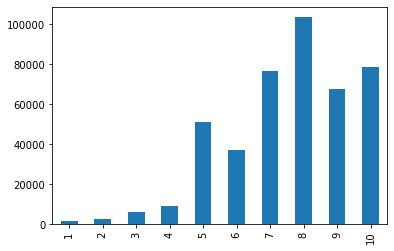

In [641]:
explicit_ratings.rating.value_counts().sort_index().plot(kind = 'bar') #users mostly rate 5 and higher
#Potentially it might be useful to roup ratings into e.g. 4 clases: 1 to 4, 5+6, 7+8, 9+10

In [642]:
#Converting explicit ratings into pivotted form in a sparse matrix (pd.pivot() cannot produce sparse it seems)
#kudos to this post: https://stackoverflow.com/questions/31661604/efficiently-create-sparse-pivot-tables-in-pandas
ISBN_c = CategoricalDtype(explicit_ratings.ISBN.unique(), ordered=False)
user_c = CategoricalDtype(explicit_ratings.user.unique(), ordered=False)

row = explicit_ratings.ISBN.astype(ISBN_c).cat.codes
col = explicit_ratings.user.astype(user_c).cat.codes
explicit_sparse_matrix = csr_matrix((explicit_ratings["rating"], (row, col)), 
                           shape=(ISBN_c.categories.size, user_c.categories.size),
                           dtype=int)

explicit_sparse_matrix
expl_index = ISBN_c.categories.get_loc(input_ISBN)

<185972x77805 sparse matrix of type '<class 'numpy.intc'>'
	with 433671 stored elements in Compressed Sparse Row format>

## Explicit Ratings - Cosine similarity

In [643]:
#Nearest Neighbors search
model = NearestNeighbors(n_neighbors = choose_n+1, algorithm = 'auto', metric='cosine')
model.fit(explicit_sparse_matrix)
distances, suggestions = model.kneighbors(explicit_sparse_matrix[expl_index,:], return_distance = True)
#Euclidean distance here does not work, because it takes 0s into consideration, so it outputs random books
#Cosine distace works, but does not account for the size of vector elements - the reviews themselves, so in the end it 
#is the same as implicit rating.
#I was also thinking about a custom distance metric based on euclidean, but dividing the distance by # of common non-zero obs., 
#but didnt finished the idea
#I will try alternative where I will keep only users (columns) that rated input_book

NearestNeighbors(metric='cosine', n_neighbors=6)

In [644]:
#Selecting the most similar books
explicit_ISBN_suggestions = ISBN_c.categories[list(suggestions[0])]
explicit_recommendations_cosine = books[books.ISBN.isin(explicit_ISBN_suggestions)
        & (~(books.title.str.contains(input_name)))][['title', 'author', 'year', 'publisher', 'explicit_ratings', 'implicit_ratings']]
#explicit_recommendations_cosine

## Explicit Ratings - Euclidean distance on common

In [645]:
#Create new sparse matrix only with the users that rated input book
_, col_indices, _ = find(explicit_sparse_matrix[expl_index,:])
subset_sparse_matrix = explicit_sparse_matrix[:, col_indices].copy()

In [646]:
subset_sparse_matrix[expl_index,:]

<1x131 sparse matrix of type '<class 'numpy.intc'>'
	with 131 stored elements in Compressed Sparse Row format>

In [647]:
#Nearest Neighbors search
model = NearestNeighbors(n_neighbors = choose_n+1, algorithm = 'auto', metric='euclidean')
model.fit(subset_sparse_matrix)
distances, suggestions = model.kneighbors(subset_sparse_matrix[expl_index,:], return_distance = True)

NearestNeighbors(metric='euclidean', n_neighbors=6)

In [648]:
#Selecting the most similar books
explicit_ISBN_suggestions = ISBN_c.categories[list(suggestions[0])]
explicit_recommendations = books[(books.ISBN.isin(explicit_ISBN_suggestions))
                              & (~(books.title.str.contains(input_name)))][['title', 'author', 'year', 'publisher', 'explicit_ratings', 'implicit_ratings']]
#explicit_recommendations

# Implicit Ratings Selection

In [649]:
#Creating the sparse pivot table for inmplicit ratings
ISBN_c = CategoricalDtype(implicit_ratings.ISBN.unique(), ordered=False)
user_c = CategoricalDtype(implicit_ratings.user.unique(), ordered=False)

row = implicit_ratings.ISBN.astype(ISBN_c).cat.codes
col = implicit_ratings.user.astype(user_c).cat.codes
implicit_sparse_matrix = csr_matrix((implicit_ratings["rating"], (row, col)), 
                           shape=(ISBN_c.categories.size, user_c.categories.size),
                           dtype=int)

implicit_sparse_matrix
impl_index = ISBN_c.categories.get_loc(input_ISBN)

<246724x59517 sparse matrix of type '<class 'numpy.intc'>'
	with 716109 stored elements in Compressed Sparse Row format>

In [650]:
#Searching with NearestNeghbors()
model = NearestNeighbors(n_neighbors = choose_n+1, algorithm = 'auto', metric='cosine')
model.fit(implicit_sparse_matrix)
distances, suggestions = model.kneighbors(implicit_sparse_matrix[impl_index,:], return_distance = True)

NearestNeighbors(metric='cosine', n_neighbors=6)

In [651]:
#Saving the result
implicit_ISBN_suggestions = ISBN_c.categories[list(suggestions[0])]
implicit_recommendations = books[(books.ISBN.isin(implicit_ISBN_suggestions))
                              & (~(books.title.str.contains(input_name)))][['title', 'author', 'year', 'publisher', 'explicit_ratings', 'implicit_ratings']]

# Recommendation

In [652]:
print(f'Selected book: {input_title} by {input_author} \n')

print('Similar books')
similar_books

print('Other readers also liked:')
explicit_recommendations

print('Others were also interested in:')
implicit_recommendations

Selected book: The Fellowship of the Ring (The Lord of the Rings, Part 1) by J.R.R. TOLKIEN 

Similar books


,title,author,year,publisher,explicit_ratings,implicit_ratings
4206,"The Return of the King (The Lord of the Rings,...",J.R.R. TOLKIEN,1986,Del Rey,77.0,96.0
780,"The Two Towers (The Lord of the Rings, Part 2)",J.R.R. TOLKIEN,1986,Del Rey,83.0,94.0
6866,The Hobbit and The Lord of the Rings,J.R.R. TOLKIEN,1986,Del Rey,6.0,2.0
3354,The Hobbit : The Enchanting Prelude to The Lor...,J.R.R. TOLKIEN,1986,Del Rey,161.0,120.0
135872,The War of the Ring (The History of The Lord o...,J.R.R. Tolkien,1990,Houghton Mifflin,1.0,NaN


Other readers also liked:


,title,author,year,publisher,explicit_ratings,implicit_ratings
780,"The Two Towers (The Lord of the Rings, Part 2)",J.R.R. TOLKIEN,1986,Del Rey,83.0,94.0
2143,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,1999,Arthur A. Levine Books,313.0,258.0
3354,The Hobbit : The Enchanting Prelude to The Lor...,J.R.R. TOLKIEN,1986,Del Rey,161.0,120.0
3459,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,2000,Scholastic,189.0,162.0
4206,"The Return of the King (The Lord of the Rings,...",J.R.R. TOLKIEN,1986,Del Rey,77.0,96.0


Others were also interested in:


,title,author,year,publisher,explicit_ratings,implicit_ratings
780,"The Two Towers (The Lord of the Rings, Part 2)",J.R.R. TOLKIEN,1986,Del Rey,83.0,94.0
3354,The Hobbit : The Enchanting Prelude to The Lor...,J.R.R. TOLKIEN,1986,Del Rey,161.0,120.0
4206,"The Return of the King (The Lord of the Rings,...",J.R.R. TOLKIEN,1986,Del Rey,77.0,96.0
26213,King of the Murgos (Malloreon (Paperback Rando...,David Eddings,1995,Del Rey Books,11.0,18.0
26214,Guardians of the West (Book 1 of the Malloreon),David Eddings,1988,Del Rey Books,15.0,29.0


# Limitations

# Further avenues